# Setting_01 - 98% accuracy on test dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load the digits dataset
digits = load_digits()
X = digits.data        # Features (1797 samples, 64 features each)
y = digits.target      # Labels (digits 0 through 9)

# Split into training and test sets (e.g., 70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [3]:
# Set top_k value
top_k = 25

In [4]:
# Random Forest Feature Selection 
def select_top_rf_features(X, y, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    top_indices = np.argsort(importances)[::-1][:k]
    return top_indices, importances

rf_indices, rf_importances = select_top_rf_features(X_train, y_train, top_k)

In [5]:
# Select top-k features
X_train_rf = X_train[:, rf_indices]
X_test_rf = X_test[:, rf_indices]

In [6]:
# PCA Feature Reduction 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=top_k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [7]:
# Train Models and Compare
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "RBF SVM": SVC(kernel='rbf', gamma='scale', random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42)
}

results = []

for name, clf in classifiers.items():
    # RF-based
    clf.fit(X_train_rf, y_train)
    acc_rf = clf.score(X_test_rf, y_test)

    # PCA-based
    clf.fit(X_train_pca, y_train)
    acc_pca = clf.score(X_test_pca, y_test)

    results.append({
        "Classifier": name,
        "RF Accuracy": acc_rf,
        "PCA Accuracy": acc_pca
    })

# Display results
df_results = pd.DataFrame(results)
print(df_results)

            Classifier  RF Accuracy  PCA Accuracy
0  Logistic Regression     0.940741      0.950000
1              RBF SVM     0.981481      0.977778
2           Linear SVM     0.957407      0.951852


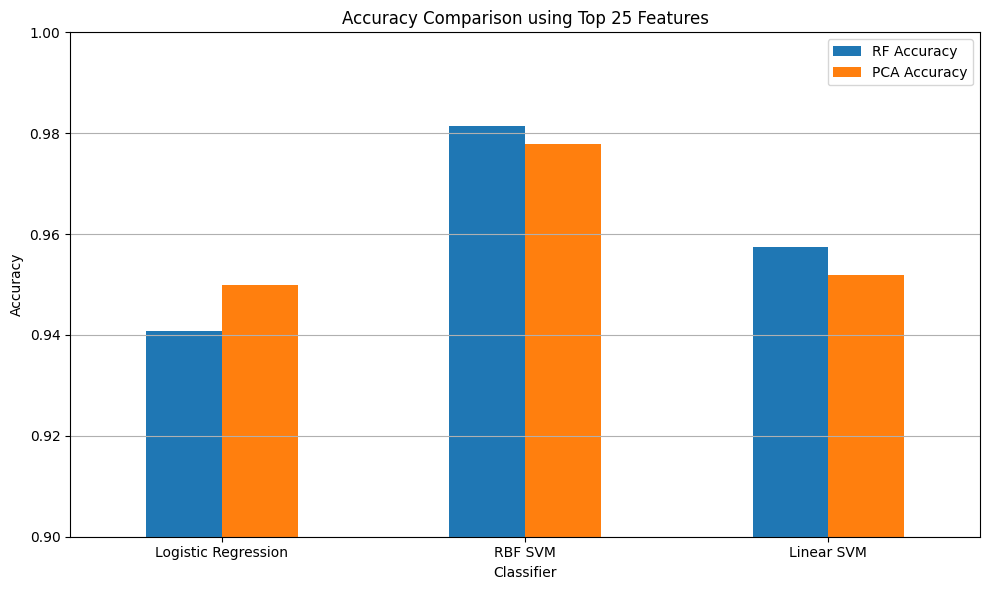

In [8]:
# Plot Accuracy Comparison 
df_results.set_index("Classifier")[["RF Accuracy", "PCA Accuracy"]].plot(kind='bar', figsize=(10, 6))
plt.title(f"Accuracy Comparison using Top {top_k} Features")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [9]:
# Hyperparameter Tuning for RBF SVM 
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf'))
])

param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': [0.001, 0.01, 0.1]
}

# GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_rf, y_train)

# Test set evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_rf)
acc = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid.best_params_)
print(f"Test Accuracy: {acc * 100:.2f}%")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'clf__C': 1, 'clf__gamma': 0.1}
Test Accuracy: 98.33%


In [10]:
# Initialize list to store accuracies
acc_list = []

# Find Minimum Number of RF Features for ≥98% Accuracy 
for k in range(16, 26):
    indices, _ = select_top_rf_features(X_train, y_train, k)
    X_train_k = X_train[:, indices]
    X_test_k = X_test[:, indices]

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', C=grid.best_params_['clf__C'], gamma=grid.best_params_['clf__gamma'], random_state=42))
    ])
    model.fit(X_train_k, y_train)
    acc_k = model.score(X_test_k, y_test)

    acc_list.append((k, acc_k))  # Store (top_k, accuracy)


    print(f"top_k = {k} → Test Accuracy = {acc_k * 100:.2f}%")
    if acc_k >= 0.98:
        best_k = k
        print(f"Minimum features for ≥98%: top_k = {k}")
        break

top_k = 16 → Test Accuracy = 95.74%
top_k = 17 → Test Accuracy = 95.93%
top_k = 18 → Test Accuracy = 96.30%
top_k = 19 → Test Accuracy = 97.41%
top_k = 20 → Test Accuracy = 97.41%
top_k = 21 → Test Accuracy = 97.59%
top_k = 22 → Test Accuracy = 97.78%
top_k = 23 → Test Accuracy = 98.15%
Minimum features for ≥98%: top_k = 23


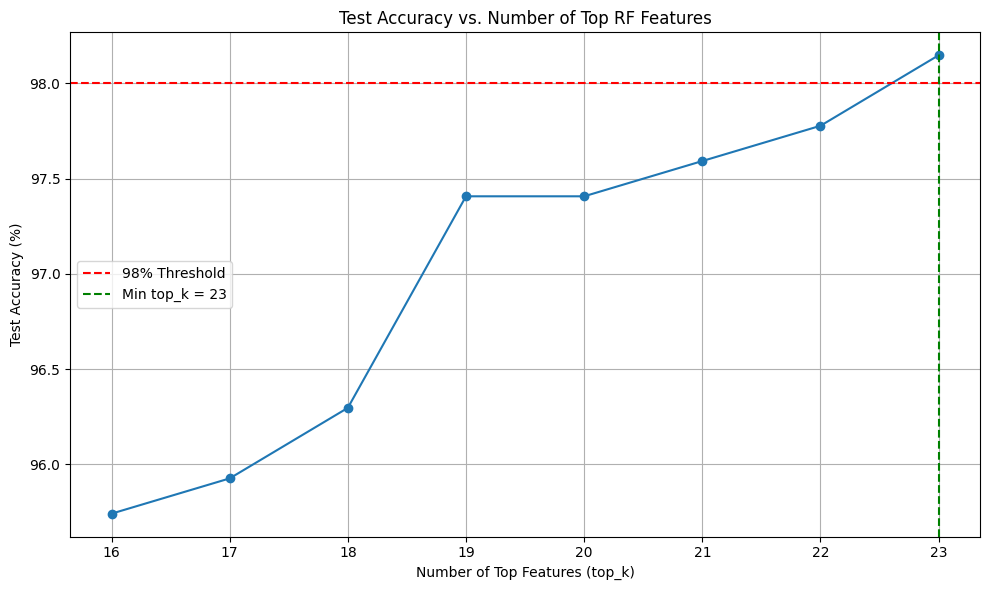

In [11]:
# Plotting Accuracy vs. top_k 
top_ks, accuracies = zip(*acc_list)

plt.figure(figsize=(10, 6))
plt.plot(top_ks, np.array(accuracies) * 100, marker='o', linestyle='-')
plt.axhline(98, color='r', linestyle='--', label='98% Threshold')
if best_k:
    plt.axvline(best_k, color='g', linestyle='--', label=f'Min top_k = {best_k}')
plt.title("Test Accuracy vs. Number of Top RF Features")
plt.xlabel("Number of Top Features (top_k)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Conclution and findings

- The goal was to find the smallest number of features needed to achieve ≥98% accuracy.
- Random Forest was used to rank features by importance.
- SVM with RBF kernel was used as the classification model.
- A loop tested top_k values from 15 to 25 to evaluate performance.
- GridSearchCV was used to tune model parameters:
    - C = 1
    - gamma = 0.1

- The model reached 98.15% accuracy with only 23 features.
- This reduces complexity from 64 features to 23.

Final setup:
- Minimum features needed: 23
- Selection method: Random Forest
- Model: SVM (RBF)
- Best parameters: C = 1, gamma = 0.1